# Data Science in Practice 2020

## Problem Set 2

### Descriptive report

Authors :
- Rayan Chaouche
- Yann Martinson
- Christopher Padovani
- Jules Triomphe

### 1. Initialization

Loading modules :

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from operator import itemgetter, attrgetter
from scipy.stats import randint as sp_randint

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import log_loss, classification_report, confusion_matrix, roc_curve, accuracy_score, roc_auc_score, precision_recall_fscore_support, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.preprocessing import StandardScaler

# import time

from matplotlib import pyplot as plt

Defining functions :

In [2]:
def df_pp() :

    df_raw = pd.read_csv('customers.csv')
    
    # clean up lines
    
    total_length = len(df_raw)
    df_raw = df_raw[df_raw['TotalCharges'] != ' ']
    df_raw.TotalCharges = df_raw.TotalCharges.astype('float')
    cleanup_length = len(df_raw)
    print('%s lines were deleted.' %(total_length - cleanup_length))
    
    # output into dummies
    
    churn_dummy_dict = {'Yes': 1, 'No': 0}
    df_raw.Churn.replace(churn_dummy_dict, inplace = True)
    
    # X y splitting
    
    y = df_raw.Churn.copy()
    X_raw = df_raw.drop(columns ='Churn').copy()
    
    # input into dummies
    
    X_raw_types = dict(X_raw.dtypes)
    features = list(X_raw.columns)
    categorical_features = [feat for feat in features if X_raw_types[feat] == 'O']
    categorical_features.remove('customerID')
    
    X = pd.get_dummies(X_raw, columns = categorical_features,prefix_sep=':')
    X = X.drop(columns = 'customerID').copy()

    return df_raw,categorical_features, X, y, cleanup_length

In [3]:
def df_preprocessing_knn() :

    df_raw,categorical_features, X, y, _ = df_pp()
    
    # train val splitting

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    y_train = y_train.tolist()
    y_test = y_test.tolist()

    return df_raw,categorical_features, X, X_train, X_test, y, y_train, y_test

In [4]:
def df_preprocessing_rf(test_size) :
    
    df_raw,categorical_features, X, y, cleanup_length = df_pp()
    
    # train val splitting

    train = np.random.rand(cleanup_length)> test_size

    X_train = X[train]
    X_test = X[~train]

    y_train = y[train].tolist()
    y_test = y[~train].tolist()

    return df_raw,categorical_features, X, X_train, X_test, y, y_train, y_test

In [5]:
def plot_importance(feature_importance_sorted, n, type_of_search):
    
    plt.figure(figsize=(15,5))
    x = np.arange(n)
    y = [feature_importance_sorted[i][1] for i in range(n)]
    labels = [feature_importance_sorted[i][0] for i in range(n)]
    ax = sns.barplot(y,x,orient="h");
    plt.xlabel("Importance fraction", fontsize = 12)
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    plt.yticks(x,labels, fontsize = 15)
    plt.title('Most important feature: {}'.format(type_of_search), fontsize = 15)
    plt.show()

### 2. K-Nearest Neighbors Classifier

We start by scaling the data.

In [6]:
df_raw,categorical_features, X, X_train, X_test, y, y_train, y_test = df_preprocessing_knn()

11 lines were deleted.


In [7]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

We run simulations for k-values between 1 and 100 to find the best fit parameters.

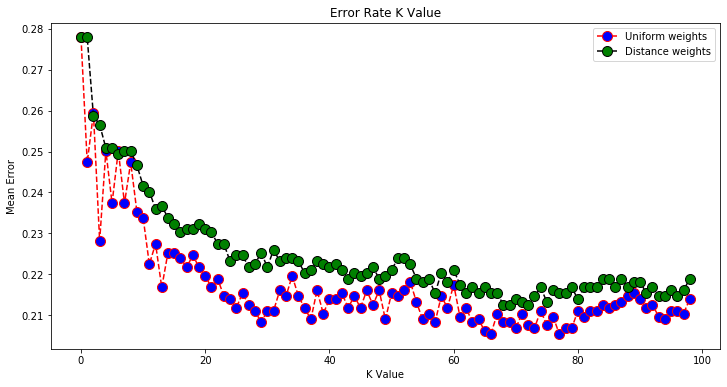

Minimum error rate with uniform weights: 20.54% for k = 67
Minimum error rate with distance weights: 21.25% for k = 69


In [8]:
error_uni = np.array([0])
error_dist = np.array([0])

for i in range(1, 100):
    knn_uni = KNeighborsClassifier(n_neighbors=i, weights='uniform')
    knn_uni.fit(X_train, y_train)
    pred_i_uni = knn_uni.predict(X_test)
    error_uni = np.append(error_uni, np.array(np.mean(pred_i_uni != y_test)))

    knn_dist = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn_dist.fit(X_train, y_train)
    pred_i_dist = knn_dist.predict(X_test)
    error_dist = np.append(error_dist, np.array(np.mean(pred_i_dist != y_test)))


plt.figure(figsize=(12, 6))
plt.plot(error_uni[1:], color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10, label='Uniform weights')
plt.plot(error_dist[1:], color='black', linestyle='dashed', marker='o', markerfacecolor='green', markersize=10, label='Distance weights')
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.legend(loc='best')
plt.show()

print('Minimum error rate with uniform weights: {:.2%} for k = {}'.format(min(error_uni[1:]), np.argmin(error_uni[1:]) + 1))
print('Minimum error rate with distance weights: {:.2%} for k = {}'.format(min(error_dist[1:]), np.argmin(error_dist[1:]) + 1))

In [9]:
classifier_uni = KNeighborsClassifier(n_neighbors = (np.argmin(error_uni[1:]) + 1), weights='uniform')
classifier_uni.fit(X_train, y_train)
classifier_dist = KNeighborsClassifier(n_neighbors = (np.argmin(error_dist[1:]) + 1), weights='distance')
classifier_dist.fit(X_train, y_train)

y_pred_uni = classifier_uni.predict(X_test)
y_pred_dist = classifier_dist.predict(X_test)

UNIFORM WEIGHTS
Accuracy: 79.46%
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1058
           1       0.58      0.59      0.59       349

    accuracy                           0.79      1407
   macro avg       0.72      0.73      0.73      1407
weighted avg       0.80      0.79      0.80      1407



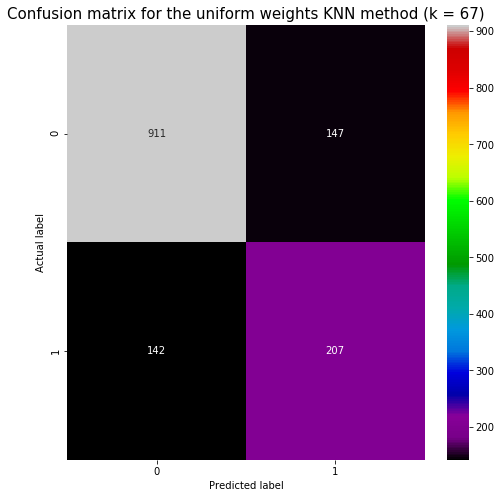

In [10]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred_uni), annot=True, fmt="d", cmap="nipy_spectral")
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion matrix for the uniform weights KNN method (k = {})'.format(np.argmin(error_uni[1:]) + 1), fontsize = 15);
print("UNIFORM WEIGHTS")
print("Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_uni)))
print(classification_report(y_test, y_pred_uni))

DISTANCE WEIGHTS
Accuracy: 78.75%
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1058
           1       0.57      0.57      0.57       349

    accuracy                           0.79      1407
   macro avg       0.72      0.72      0.72      1407
weighted avg       0.79      0.79      0.79      1407



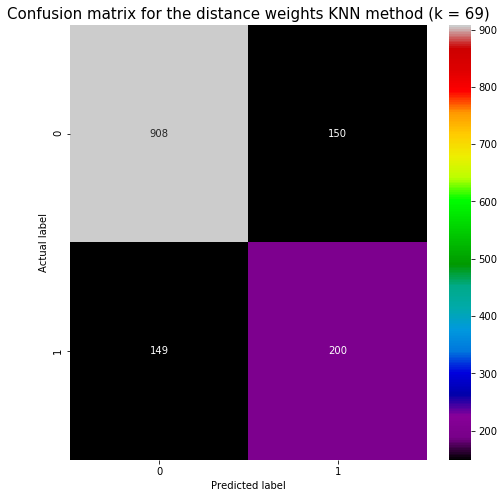

In [11]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred_dist), annot=True, fmt="d", cmap="nipy_spectral")
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion matrix for the distance weights KNN method (k = {})'.format(np.argmin(error_dist[1:]) + 1), fontsize = 15);
print("DISTANCE WEIGHTS")
print("Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_dist)))
print(classification_report(y_test, y_pred_dist))

### 3. Random Forest Classifier

We will compare two methods, which are grid search and random search.

In [12]:
df_raw,categorical_features, X, X_train, X_test, y, y_train, y_test = df_preprocessing_rf(0.3)

11 lines were deleted.


In [13]:
clf = RandomForestClassifier(n_jobs=-1)

#### 3.1 Grid search

To avoid having too high a computational time, we will focus on 2 of the mot important parameters that are max depth and the number of estimators.

##### Max Depth

This parameter is the depth of the trees, which is one of the most important. We range it between 4 (anything lower seems too low and imcreases computational time without much results) and 15.

##### Number of estimators

This parameter is the number of trees that are going to be generated. Here the choice of the number of trees will mostly affect the computational time. Let's set the values between 10 and 500 and see the effects.

In [14]:
max_depth = list(range(4,16))

In [15]:
n_estimators = [10, 15, 20, 50, 100, 200, 500]

Let's use the default 5 folds of cross validation.

In [16]:
grid_parameters = {'max_depth' : max_depth, 'n_estimators' : n_estimators }

In [17]:
grid_clf = GridSearchCV(clf, param_grid = grid_parameters, verbose = 3)

In [18]:
grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] max_depth=4, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ max_depth=4, n_estimators=10, score=0.796, total=   7.7s
[CV] max_depth=4, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s


[CV] ........ max_depth=4, n_estimators=10, score=0.786, total=   0.2s
[CV] max_depth=4, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s


[CV] ........ max_depth=4, n_estimators=10, score=0.765, total=   0.3s
[CV] max_depth=4, n_estimators=10 ....................................
[CV] ........ max_depth=4, n_estimators=10, score=0.781, total=   0.2s
[CV] max_depth=4, n_estimators=10 ....................................
[CV] ........ max_depth=4, n_estimators=10, score=0.795, total=   0.3s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ........ max_depth=4, n_estimators=15, score=0.799, total=   0.3s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ........ max_depth=4, n_estimators=15, score=0.780, total=   0.3s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ........ max_depth=4, n_estimators=15, score=0.769, total=   0.3s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ........ max_depth=4, n_estimators=15, score=0.790, total=   0.3s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] .

[CV] ....... max_depth=5, n_estimators=200, score=0.800, total=   1.8s
[CV] max_depth=5, n_estimators=200 ...................................
[CV] ....... max_depth=5, n_estimators=200, score=0.789, total=   1.9s
[CV] max_depth=5, n_estimators=200 ...................................
[CV] ....... max_depth=5, n_estimators=200, score=0.767, total=   1.7s
[CV] max_depth=5, n_estimators=200 ...................................
[CV] ....... max_depth=5, n_estimators=200, score=0.796, total=   1.8s
[CV] max_depth=5, n_estimators=200 ...................................
[CV] ....... max_depth=5, n_estimators=200, score=0.795, total=   1.8s
[CV] max_depth=5, n_estimators=500 ...................................
[CV] ....... max_depth=5, n_estimators=500, score=0.804, total=   3.9s
[CV] max_depth=5, n_estimators=500 ...................................
[CV] ....... max_depth=5, n_estimators=500, score=0.791, total=   5.2s
[CV] max_depth=5, n_estimators=500 ...................................
[CV] .

[CV] ........ max_depth=7, n_estimators=20, score=0.797, total=   0.4s
[CV] max_depth=7, n_estimators=20 ....................................
[CV] ........ max_depth=7, n_estimators=20, score=0.807, total=   0.5s
[CV] max_depth=7, n_estimators=50 ....................................
[CV] ........ max_depth=7, n_estimators=50, score=0.809, total=   0.7s
[CV] max_depth=7, n_estimators=50 ....................................
[CV] ........ max_depth=7, n_estimators=50, score=0.803, total=   0.8s
[CV] max_depth=7, n_estimators=50 ....................................
[CV] ........ max_depth=7, n_estimators=50, score=0.772, total=   0.7s
[CV] max_depth=7, n_estimators=50 ....................................
[CV] ........ max_depth=7, n_estimators=50, score=0.809, total=   0.7s
[CV] max_depth=7, n_estimators=50 ....................................
[CV] ........ max_depth=7, n_estimators=50, score=0.804, total=   0.8s
[CV] max_depth=7, n_estimators=100 ...................................
[CV] .

[CV] ........ max_depth=9, n_estimators=10, score=0.791, total=   0.3s
[CV] max_depth=9, n_estimators=10 ....................................
[CV] ........ max_depth=9, n_estimators=10, score=0.773, total=   0.3s
[CV] max_depth=9, n_estimators=10 ....................................
[CV] ........ max_depth=9, n_estimators=10, score=0.782, total=   0.3s
[CV] max_depth=9, n_estimators=10 ....................................
[CV] ........ max_depth=9, n_estimators=10, score=0.794, total=   0.3s
[CV] max_depth=9, n_estimators=15 ....................................
[CV] ........ max_depth=9, n_estimators=15, score=0.802, total=   0.4s
[CV] max_depth=9, n_estimators=15 ....................................
[CV] ........ max_depth=9, n_estimators=15, score=0.793, total=   0.4s
[CV] max_depth=9, n_estimators=15 ....................................
[CV] ........ max_depth=9, n_estimators=15, score=0.779, total=   0.4s
[CV] max_depth=9, n_estimators=15 ....................................
[CV] .

[CV] ...... max_depth=10, n_estimators=100, score=0.800, total=   1.4s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.810, total=   2.6s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.799, total=   2.6s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.777, total=   2.5s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.803, total=   2.5s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.802, total=   2.7s
[CV] max_depth=10, n_estimators=500 ..................................
[CV] ...... max_depth=10, n_estimators=500, score=0.811, total=   6.2s
[CV] max_depth=10, n_estimators=500 ..................................
[CV] .

[CV] ....... max_depth=12, n_estimators=20, score=0.758, total=   0.4s
[CV] max_depth=12, n_estimators=20 ...................................
[CV] ....... max_depth=12, n_estimators=20, score=0.794, total=   0.4s
[CV] max_depth=12, n_estimators=20 ...................................
[CV] ....... max_depth=12, n_estimators=20, score=0.790, total=   0.4s
[CV] max_depth=12, n_estimators=50 ...................................
[CV] ....... max_depth=12, n_estimators=50, score=0.796, total=   0.8s
[CV] max_depth=12, n_estimators=50 ...................................
[CV] ....... max_depth=12, n_estimators=50, score=0.800, total=   0.8s
[CV] max_depth=12, n_estimators=50 ...................................
[CV] ....... max_depth=12, n_estimators=50, score=0.777, total=   0.7s
[CV] max_depth=12, n_estimators=50 ...................................
[CV] ....... max_depth=12, n_estimators=50, score=0.790, total=   0.7s
[CV] max_depth=12, n_estimators=50 ...................................
[CV] .

[CV] ....... max_depth=14, n_estimators=10, score=0.793, total=   0.3s
[CV] max_depth=14, n_estimators=10 ...................................
[CV] ....... max_depth=14, n_estimators=10, score=0.792, total=   0.3s
[CV] max_depth=14, n_estimators=10 ...................................
[CV] ....... max_depth=14, n_estimators=10, score=0.769, total=   0.3s
[CV] max_depth=14, n_estimators=10 ...................................
[CV] ....... max_depth=14, n_estimators=10, score=0.783, total=   0.3s
[CV] max_depth=14, n_estimators=10 ...................................
[CV] ....... max_depth=14, n_estimators=10, score=0.796, total=   0.4s
[CV] max_depth=14, n_estimators=15 ...................................
[CV] ....... max_depth=14, n_estimators=15, score=0.793, total=   0.4s
[CV] max_depth=14, n_estimators=15 ...................................
[CV] ....... max_depth=14, n_estimators=15, score=0.786, total=   0.4s
[CV] max_depth=14, n_estimators=15 ...................................
[CV] .

[CV] ...... max_depth=15, n_estimators=100, score=0.785, total=   1.3s
[CV] max_depth=15, n_estimators=100 ..................................
[CV] ...... max_depth=15, n_estimators=100, score=0.795, total=   1.2s
[CV] max_depth=15, n_estimators=200 ..................................
[CV] ...... max_depth=15, n_estimators=200, score=0.793, total=   2.9s
[CV] max_depth=15, n_estimators=200 ..................................
[CV] ...... max_depth=15, n_estimators=200, score=0.778, total=   2.7s
[CV] max_depth=15, n_estimators=200 ..................................
[CV] ...... max_depth=15, n_estimators=200, score=0.772, total=   3.2s
[CV] max_depth=15, n_estimators=200 ..................................
[CV] ...... max_depth=15, n_estimators=200, score=0.784, total=   2.7s
[CV] max_depth=15, n_estimators=200 ..................................
[CV] ...... max_depth=15, n_estimators=200, score=0.796, total=   3.1s
[CV] max_depth=15, n_estimators=500 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed: 12.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              rand

Let's check which model is the best.

In [19]:
grid_best_score = grid_clf.best_score_
grid_best_parameters = grid_clf.best_params_
grid_best_max_depth = grid_best_parameters.get('max_depth')
grid_best_n_estimators = grid_best_parameters.get('n_estimators')

print('Grid search best_score: {:.5}'.format(grid_best_score))
print('best_max_depth: {}'.format(grid_best_max_depth))
print('best_n_estimators: {}'.format(grid_best_n_estimators))

Grid search best_score: 0.79992
best_max_depth: 7
best_n_estimators: 10


In [20]:
grid_clf_best = RandomForestClassifier(n_jobs = -1,max_depth = grid_best_max_depth, n_estimators = grid_best_n_estimators )

In [21]:
grid_clf_best.fit(X_train, y_train);

Let's apply it to our validation set.

In [22]:
grid_y_pred = grid_clf_best.predict(X_test)

In [23]:
print("Accuracy: {:.2%}".format(accuracy_score(y_test, grid_y_pred)))

Accuracy: 81.21%


Given this accuracy, we can take a deeper look into the results.

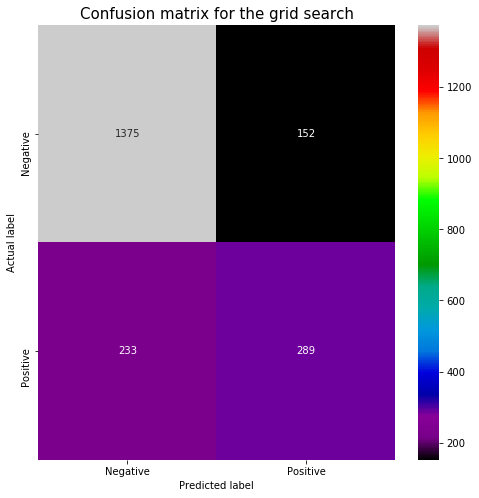

In [24]:
grid_cm = confusion_matrix(y_test, grid_y_pred)
index = ['Negative','Positive']  
columns = ['Negative','Positive']  
cm_df = pd.DataFrame(grid_cm,columns,index) 


plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="nipy_spectral")
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion matrix for the grid search', fontsize = 15);

##### Feature importance

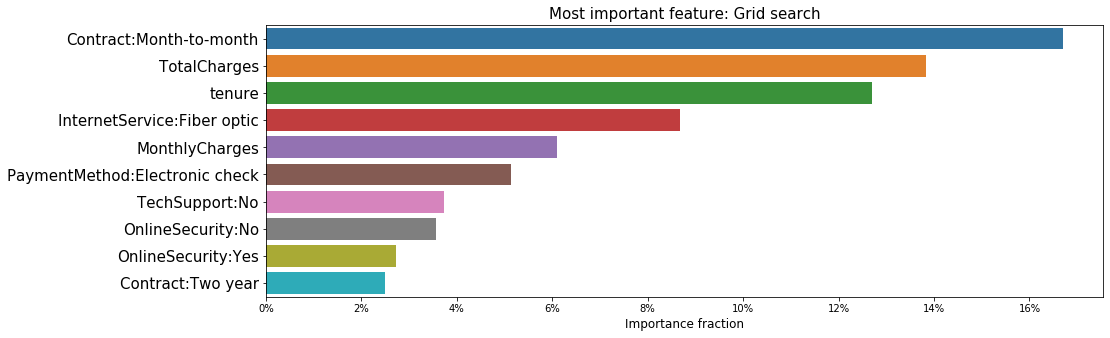

In [25]:
grid_feature_importances = [(list(X.columns)[i], grid_clf_best.feature_importances_[i]) for i in range(len(list(X.columns)))]
grid_feature_importances.sort(key=itemgetter(1), reverse = True)
plot_importance(grid_feature_importances, 10, 'Grid search')

In [26]:
print(classification_report(y_test,grid_y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1527
           1       0.66      0.55      0.60       522

    accuracy                           0.81      2049
   macro avg       0.76      0.73      0.74      2049
weighted avg       0.80      0.81      0.81      2049



##### Feature selection

Let's try to run the model again, but this time selecting only the most impacting features to save us some work and let's compare the results.

In [27]:
grid_selected_features = [grid_feature_importances[i][0] for i in range(15)]
grid_X_train_sel = X_train[grid_selected_features]
grid_X_test_sel = X_test[grid_selected_features]

In [28]:
grid_clf.fit(grid_X_train_sel, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] max_depth=4, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ max_depth=4, n_estimators=10, score=0.797, total=   0.4s
[CV] max_depth=4, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ........ max_depth=4, n_estimators=10, score=0.780, total=   0.2s
[CV] max_depth=4, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] ........ max_depth=4, n_estimators=10, score=0.773, total=   0.3s
[CV] max_depth=4, n_estimators=10 ....................................
[CV] ........ max_depth=4, n_estimators=10, score=0.792, total=   0.2s
[CV] max_depth=4, n_estimators=10 ....................................
[CV] ........ max_depth=4, n_estimators=10, score=0.801, total=   0.3s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ........ max_depth=4, n_estimators=15, score=0.799, total=   0.3s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ........ max_depth=4, n_estimators=15, score=0.791, total=   0.3s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ........ max_depth=4, n_estimators=15, score=0.767, total=   0.3s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ........ max_depth=4, n_estimators=15, score=0.791, total=   0.3s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] .

[CV] ....... max_depth=5, n_estimators=200, score=0.802, total=   1.8s
[CV] max_depth=5, n_estimators=200 ...................................
[CV] ....... max_depth=5, n_estimators=200, score=0.790, total=   1.8s
[CV] max_depth=5, n_estimators=200 ...................................
[CV] ....... max_depth=5, n_estimators=200, score=0.771, total=   1.9s
[CV] max_depth=5, n_estimators=200 ...................................
[CV] ....... max_depth=5, n_estimators=200, score=0.802, total=   1.7s
[CV] max_depth=5, n_estimators=200 ...................................
[CV] ....... max_depth=5, n_estimators=200, score=0.797, total=   1.8s
[CV] max_depth=5, n_estimators=500 ...................................
[CV] ....... max_depth=5, n_estimators=500, score=0.805, total=   4.5s
[CV] max_depth=5, n_estimators=500 ...................................
[CV] ....... max_depth=5, n_estimators=500, score=0.792, total=   6.5s
[CV] max_depth=5, n_estimators=500 ...................................
[CV] .

[CV] ........ max_depth=7, n_estimators=20, score=0.784, total=   0.4s
[CV] max_depth=7, n_estimators=20 ....................................
[CV] ........ max_depth=7, n_estimators=20, score=0.800, total=   0.3s
[CV] max_depth=7, n_estimators=50 ....................................
[CV] ........ max_depth=7, n_estimators=50, score=0.810, total=   0.5s
[CV] max_depth=7, n_estimators=50 ....................................
[CV] ........ max_depth=7, n_estimators=50, score=0.794, total=   0.6s
[CV] max_depth=7, n_estimators=50 ....................................
[CV] ........ max_depth=7, n_estimators=50, score=0.780, total=   0.6s
[CV] max_depth=7, n_estimators=50 ....................................
[CV] ........ max_depth=7, n_estimators=50, score=0.792, total=   0.6s
[CV] max_depth=7, n_estimators=50 ....................................
[CV] ........ max_depth=7, n_estimators=50, score=0.791, total=   0.6s
[CV] max_depth=7, n_estimators=100 ...................................
[CV] .

[CV] ........ max_depth=9, n_estimators=10, score=0.794, total=   0.3s
[CV] max_depth=9, n_estimators=10 ....................................
[CV] ........ max_depth=9, n_estimators=10, score=0.778, total=   0.3s
[CV] max_depth=9, n_estimators=10 ....................................
[CV] ........ max_depth=9, n_estimators=10, score=0.780, total=   0.2s
[CV] max_depth=9, n_estimators=10 ....................................
[CV] ........ max_depth=9, n_estimators=10, score=0.790, total=   0.3s
[CV] max_depth=9, n_estimators=15 ....................................
[CV] ........ max_depth=9, n_estimators=15, score=0.803, total=   0.3s
[CV] max_depth=9, n_estimators=15 ....................................
[CV] ........ max_depth=9, n_estimators=15, score=0.792, total=   0.3s
[CV] max_depth=9, n_estimators=15 ....................................
[CV] ........ max_depth=9, n_estimators=15, score=0.777, total=   0.3s
[CV] max_depth=9, n_estimators=15 ....................................
[CV] .

[CV] ...... max_depth=10, n_estimators=100, score=0.794, total=   1.1s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.803, total=   2.0s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.789, total=   2.2s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.781, total=   2.2s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.783, total=   2.1s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.798, total=   2.3s
[CV] max_depth=10, n_estimators=500 ..................................
[CV] ...... max_depth=10, n_estimators=500, score=0.798, total=   5.2s
[CV] max_depth=10, n_estimators=500 ..................................
[CV] .

[CV] ....... max_depth=12, n_estimators=20, score=0.772, total=   0.4s
[CV] max_depth=12, n_estimators=20 ...................................
[CV] ....... max_depth=12, n_estimators=20, score=0.781, total=   0.4s
[CV] max_depth=12, n_estimators=20 ...................................
[CV] ....... max_depth=12, n_estimators=20, score=0.786, total=   0.4s
[CV] max_depth=12, n_estimators=50 ...................................
[CV] ....... max_depth=12, n_estimators=50, score=0.794, total=   0.8s
[CV] max_depth=12, n_estimators=50 ...................................
[CV] ....... max_depth=12, n_estimators=50, score=0.782, total=   1.0s
[CV] max_depth=12, n_estimators=50 ...................................
[CV] ....... max_depth=12, n_estimators=50, score=0.774, total=   1.2s
[CV] max_depth=12, n_estimators=50 ...................................
[CV] ....... max_depth=12, n_estimators=50, score=0.775, total=   0.9s
[CV] max_depth=12, n_estimators=50 ...................................
[CV] .

[CV] ....... max_depth=14, n_estimators=10, score=0.762, total=   0.3s
[CV] max_depth=14, n_estimators=10 ...................................
[CV] ....... max_depth=14, n_estimators=10, score=0.792, total=   0.3s
[CV] max_depth=14, n_estimators=10 ...................................
[CV] ....... max_depth=14, n_estimators=10, score=0.755, total=   0.3s
[CV] max_depth=14, n_estimators=10 ...................................
[CV] ....... max_depth=14, n_estimators=10, score=0.763, total=   0.3s
[CV] max_depth=14, n_estimators=10 ...................................
[CV] ....... max_depth=14, n_estimators=10, score=0.781, total=   0.2s
[CV] max_depth=14, n_estimators=15 ...................................
[CV] ....... max_depth=14, n_estimators=15, score=0.778, total=   0.4s
[CV] max_depth=14, n_estimators=15 ...................................
[CV] ....... max_depth=14, n_estimators=15, score=0.779, total=   0.4s
[CV] max_depth=14, n_estimators=15 ...................................
[CV] .

[CV] ...... max_depth=15, n_estimators=100, score=0.779, total=   1.2s
[CV] max_depth=15, n_estimators=100 ..................................
[CV] ...... max_depth=15, n_estimators=100, score=0.799, total=   1.3s
[CV] max_depth=15, n_estimators=200 ..................................
[CV] ...... max_depth=15, n_estimators=200, score=0.782, total=   2.5s
[CV] max_depth=15, n_estimators=200 ..................................
[CV] ...... max_depth=15, n_estimators=200, score=0.783, total=   2.4s
[CV] max_depth=15, n_estimators=200 ..................................
[CV] ...... max_depth=15, n_estimators=200, score=0.764, total=   2.3s
[CV] max_depth=15, n_estimators=200 ..................................
[CV] ...... max_depth=15, n_estimators=200, score=0.774, total=   2.1s
[CV] max_depth=15, n_estimators=200 ..................................
[CV] ...... max_depth=15, n_estimators=200, score=0.797, total=   2.6s
[CV] max_depth=15, n_estimators=500 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed: 10.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              rand

In [29]:
grid_best_score_sel = grid_clf.best_score_
grid_best_parameters_sel = grid_clf.best_params_
grid_best_max_depth_sel = grid_best_parameters.get('max_depth')
grid_best_n_estimators_sel = grid_best_parameters.get('n_estimators')
print('Grid search best_score with selected features: {:.5}'.format(grid_best_score_sel))
print('Grid search best_max_depth with selected features: {}'.format(grid_best_max_depth_sel))
print('Grid search best_n_estimators with selected features: {}'.format(grid_best_n_estimators_sel))

Grid search best_score with selected features: 0.79751
Grid search best_max_depth with selected features: 7
Grid search best_n_estimators with selected features: 10


In [30]:
grid_clf_best_sel = RandomForestClassifier(n_jobs = -1,max_depth = grid_best_max_depth_sel, n_estimators = grid_best_n_estimators_sel )

In [31]:
grid_clf_best_sel.fit(grid_X_train_sel, y_train);

In [32]:
grid_y_pred_sel = grid_clf_best_sel.predict(grid_X_test_sel)

In [33]:
print("Accuracy: {:.2%}".format(accuracy_score(y_test, grid_y_pred_sel)))

Accuracy: 80.38%


#### 3.2 Random Search

After having explored a grid search, we can adopt another approach. Instead of searching for each value, let's give our model more parameters input, but instead let it choose randomly at each iteration one value for each parameter. It will then be evaluated again.

In [34]:
n_estimators = range(10,1000,50)
criterion = ['gini', 'entropy']
max_features = ['sqrt', 'log2', None]
bootstrap = [True,False]
max_depth = range(5,50,10)
min_samples_leaf = range(2,100, 2)
min_samples_split = range(2,100,2)

random_parameters = {'n_estimators':n_estimators, 'max_features':max_features, 'max_depth':max_depth, 'min_samples_leaf':
              min_samples_leaf}


In [35]:
random_clf = RandomizedSearchCV(clf, param_distributions = random_parameters, n_iter = 20, verbose = 3)

In [36]:
random_clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] n_estimators=410, min_samples_leaf=18, max_features=sqrt, max_depth=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=410, min_samples_leaf=18, max_features=sqrt, max_depth=5, score=0.803, total=   3.9s
[CV] n_estimators=410, min_samples_leaf=18, max_features=sqrt, max_depth=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV]  n_estimators=410, min_samples_leaf=18, max_features=sqrt, max_depth=5, score=0.789, total=   4.1s
[CV] n_estimators=410, min_samples_leaf=18, max_features=sqrt, max_depth=5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s


[CV]  n_estimators=410, min_samples_leaf=18, max_features=sqrt, max_depth=5, score=0.771, total=   4.3s
[CV] n_estimators=410, min_samples_leaf=18, max_features=sqrt, max_depth=5 
[CV]  n_estimators=410, min_samples_leaf=18, max_features=sqrt, max_depth=5, score=0.795, total=   4.9s
[CV] n_estimators=410, min_samples_leaf=18, max_features=sqrt, max_depth=5 
[CV]  n_estimators=410, min_samples_leaf=18, max_features=sqrt, max_depth=5, score=0.799, total=   4.2s
[CV] n_estimators=10, min_samples_leaf=72, max_features=log2, max_depth=45 
[CV]  n_estimators=10, min_samples_leaf=72, max_features=log2, max_depth=45, score=0.805, total=   0.3s
[CV] n_estimators=10, min_samples_leaf=72, max_features=log2, max_depth=45 
[CV]  n_estimators=10, min_samples_leaf=72, max_features=log2, max_depth=45, score=0.801, total=   0.3s
[CV] n_estimators=10, min_samples_leaf=72, max_features=log2, max_depth=45 
[CV]  n_estimators=10, min_samples_leaf=72, max_features=log2, max_depth=45, score=0.768, total=   0

[CV]  n_estimators=660, min_samples_leaf=78, max_features=log2, max_depth=25, score=0.790, total=   6.0s
[CV] n_estimators=660, min_samples_leaf=78, max_features=log2, max_depth=25 
[CV]  n_estimators=660, min_samples_leaf=78, max_features=log2, max_depth=25, score=0.801, total=   5.8s
[CV] n_estimators=310, min_samples_leaf=66, max_features=None, max_depth=25 
[CV]  n_estimators=310, min_samples_leaf=66, max_features=None, max_depth=25, score=0.828, total=   6.3s
[CV] n_estimators=310, min_samples_leaf=66, max_features=None, max_depth=25 
[CV]  n_estimators=310, min_samples_leaf=66, max_features=None, max_depth=25, score=0.786, total=   6.7s
[CV] n_estimators=310, min_samples_leaf=66, max_features=None, max_depth=25 
[CV]  n_estimators=310, min_samples_leaf=66, max_features=None, max_depth=25, score=0.773, total=   6.5s
[CV] n_estimators=310, min_samples_leaf=66, max_features=None, max_depth=25 
[CV]  n_estimators=310, min_samples_leaf=66, max_features=None, max_depth=25, score=0.790,

[CV]  n_estimators=260, min_samples_leaf=46, max_features=sqrt, max_depth=45, score=0.796, total=   3.1s
[CV] n_estimators=260, min_samples_leaf=14, max_features=None, max_depth=15 
[CV]  n_estimators=260, min_samples_leaf=14, max_features=None, max_depth=15, score=0.812, total=   9.0s
[CV] n_estimators=260, min_samples_leaf=14, max_features=None, max_depth=15 
[CV]  n_estimators=260, min_samples_leaf=14, max_features=None, max_depth=15, score=0.795, total=   5.8s
[CV] n_estimators=260, min_samples_leaf=14, max_features=None, max_depth=15 
[CV]  n_estimators=260, min_samples_leaf=14, max_features=None, max_depth=15, score=0.776, total=   5.1s
[CV] n_estimators=260, min_samples_leaf=14, max_features=None, max_depth=15 
[CV]  n_estimators=260, min_samples_leaf=14, max_features=None, max_depth=15, score=0.793, total=   6.5s
[CV] n_estimators=260, min_samples_leaf=14, max_features=None, max_depth=15 
[CV]  n_estimators=260, min_samples_leaf=14, max_features=None, max_depth=15, score=0.805,

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  7.6min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [37]:
random_best_score = random_clf.best_score_
print('Random search best_score: {:.4}'.format(random_best_score))
random_best_parameters = random_clf.best_params_

Random search best_score: 0.7999


In [38]:
random_best_parameters

{'n_estimators': 560,
 'min_samples_leaf': 18,
 'max_features': 'sqrt',
 'max_depth': 15}

In [39]:
random_clf_best = RandomForestClassifier(max_depth = 35, max_features = 'sqrt', min_samples_leaf = 9, n_estimators = 250)

In [40]:
random_clf_best.fit(X_train, y_train);

In [41]:
random_y_pred = random_clf_best.predict(X_test)

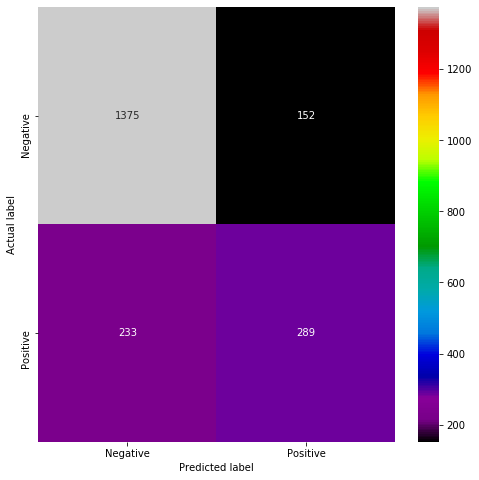

In [42]:
random_cm = confusion_matrix(y_test, random_y_pred)
annot_kws = {"ha": 'center',"va": 'center'}


plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="nipy_spectral")
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

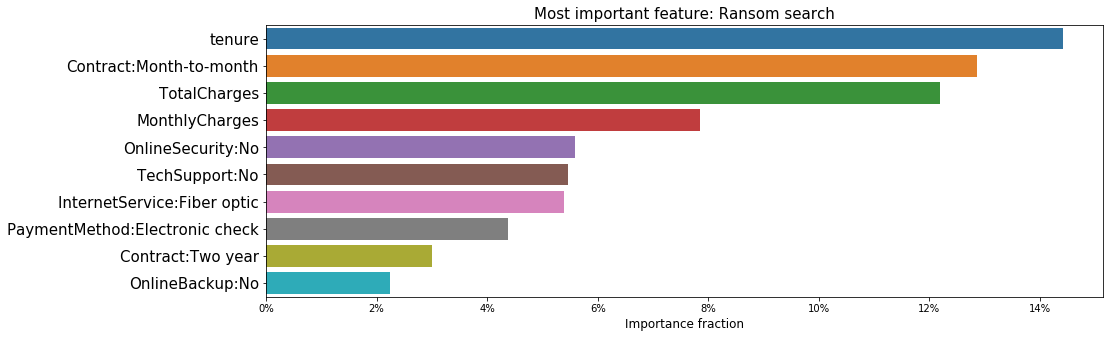

In [43]:
random_feature_importances = [(list(X.columns)[i], random_clf_best.feature_importances_[i]) for i in range(len(list(X.columns)))]
random_feature_importances.sort(key=itemgetter(1), reverse = True)
plot_importance(random_feature_importances, 10, 'Ransom search')

In [44]:
print(classification_report(y_test,random_y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1527
           1       0.67      0.51      0.58       522

    accuracy                           0.81      2049
   macro avg       0.76      0.71      0.73      2049
weighted avg       0.80      0.81      0.80      2049



In [45]:
print("Accuracy: {:.2%}".format(accuracy_score(y_test, random_y_pred)))

Accuracy: 81.02%


#### 3.3 Comparison

##### ROC Curve

In [46]:
fpr_grid, tpr_grid, _ = roc_curve(y_test, grid_y_pred)
fpr_grid_sel, tpr_grid_sel, _ = roc_curve(y_test, grid_y_pred_sel)
fpr_random, tpr_random, _ = roc_curve(y_test, random_y_pred)

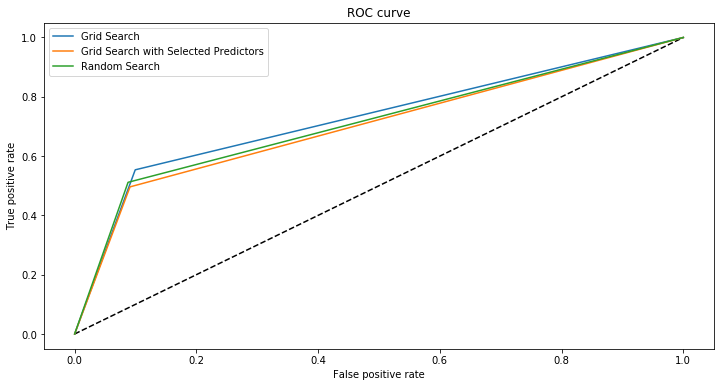

ROC AUC for Grid Search: 0.72705
ROC AUC for Grid Search with selected predictors: 0.70257
ROC AUC for Random Search: 0.71187


In [47]:
plt.figure(figsize=(12, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_grid, tpr_grid, label='Grid Search')
plt.plot(fpr_grid_sel, tpr_grid_sel, label='Grid Search with Selected Predictors')
plt.plot(fpr_random, tpr_random, label='Random Search')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

roc_auc_grid = roc_auc_score(y_test, grid_y_pred)
print('ROC AUC for Grid Search: %.5f' % roc_auc_grid)
roc_auc_grid_sel = roc_auc_score(y_test, grid_y_pred_sel)
print('ROC AUC for Grid Search with selected predictors: %.5f' % roc_auc_grid_sel)
roc_auc_random = roc_auc_score(y_test, random_y_pred)
print('ROC AUC for Random Search: %.5f' % roc_auc_random)

We observe that all three methods are better than a random prediction. The Grid Search with Selected Predictors has slightly better prediction than the Random Search, which has in turn slightly better prediction than the basic Grid Search.

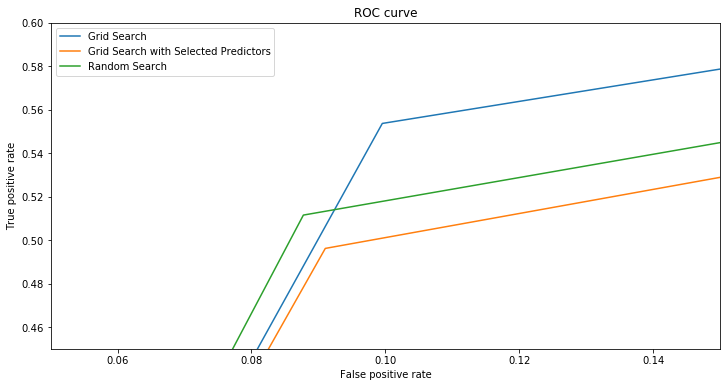

In [48]:
plt.figure(figsize=(12, 6))
plt.xlim(0.05, 0.15)
plt.ylim(0.45, 0.6)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_grid, tpr_grid, label='Grid Search')
plt.plot(fpr_grid_sel, tpr_grid_sel, label='Grid Search with Selected Predictors')
plt.plot(fpr_random, tpr_random, label='Random Search')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

##### Precision - Recall Curve

In [49]:
grid_precision, grid_recall, _ = precision_recall_curve(y_test, grid_y_pred)
grid_precision_sel, grid_recall_sel, _ = precision_recall_curve(y_test, grid_y_pred_sel)
random_precision, random_recall, _ = precision_recall_curve(y_test, random_y_pred)

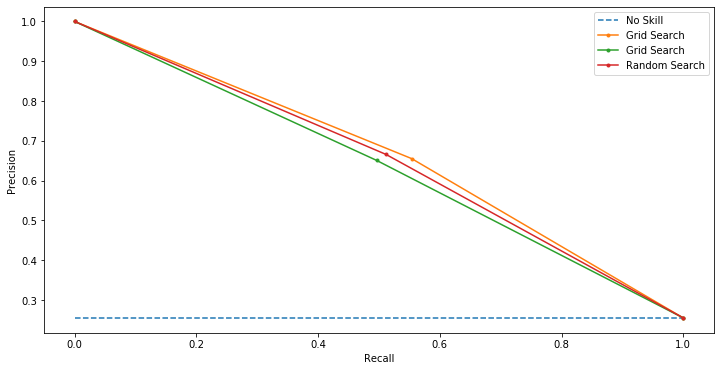

Precision-Recall AUC for Grid Search: 0.66134
Precision-Recall AUC for Grid Search with selected predictors: 0.63764
Precision-Recall AUC for Random Search: 0.65089


In [50]:
y_test = np.array(y_test)
no_skill = len(y_test[y_test == 1]) / len(y_test)

plt.figure(figsize=(12, 6))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(grid_recall, grid_precision, marker='.', label='Grid Search')
plt.plot(grid_recall_sel, grid_precision_sel, marker='.', label='Grid Search')
plt.plot(random_recall, random_precision, marker='.', label='Random Search')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

pr_auc_grid = auc(grid_recall, grid_precision)
print('Precision-Recall AUC for Grid Search: %.5f' % pr_auc_grid)
pr_auc_grid_sel = auc(grid_recall_sel, grid_precision_sel)
print('Precision-Recall AUC for Grid Search with selected predictors: %.5f' % pr_auc_grid_sel)
pr_auc_random = auc(random_recall, random_precision)
print('Precision-Recall AUC for Random Search: %.5f' % pr_auc_random)

### 4. Conclusion

We illustrated two main methods which are K Nearest Neighbors and Random Forest. Each of these methods can be used differently, given the different inputs we give them or the approach we want to have. In the long run, we see that all of them approach a 80% accuracy, with small differences among them. 

Analyzing the feature importance can give the company some insights into what is affecting the rate of churn and how it could help them retain a higher number of customers.